In [1]:
!pip install langgraph "langgraph[aws]"

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages


In [3]:
class State(TypedDict):
    """State for the graph."""
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)


Creating a tool from scratch using langchain

In [4]:
from langchain_core.tools import tool
@tool
def greet(name: str) -> str:
    """Greet a person with their name."""
    return f"Hello, {name}!"
tools = [greet]
greet.invoke("Dinesh")

'Hello, Dinesh!'

Loading the model, binding the tools to the model and created a chatbot node to use the tool binded model

In [5]:
from langchain.chat_models import init_chat_model
model = init_chat_model("anthropic.claude-3-5-sonnet-20240620-v1:0", model_provider="bedrock_converse")
model_wth_tools = model.bind_tools(tools)
def chatbot(state: State) -> State:
    """Chatbot function to handle messages."""
    # response = model.invoke(state["messages"])
    # print(response)
    # state["messages"].append(response)
    # return state
    return {"messages": [model_wth_tools.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)

To enable tool execution, we need to define a function that determines whether a tool should be invoked based on the model's latest response. This function will inspect the most recent message in the conversation state. If the response includes a tool_calls field, it indicates that the LLM intends to use one or more tools. In that case, the function will proceed to invoke the appropriate tools.

To make this process effective, it’s important to design the prompt in a way that guides the LLM to recognize when a tool is needed and respond accordingly—clearly indicating the intention to 'call tools'.

In [6]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
  def __init__(self, tools) -> None:
    self.tools_by_name = {tool.name: tool for tool in tools}
  def __call__(self, inputs:dict):
    if messages := inputs.get("messages", []):
      message = messages[-1]
    else:
      raise ValueError("No messages found in inputs.")
    outputs = []
    for tool_call in message.tool_calls:
      tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
      outputs.append(
        ToolMessage(
          content = json.dumps(tool_result),
          name = tool_call["name"],
          tool_call_id = tool_call["id"]
        )
      )
    return {"messages": outputs}
tool_node = BasicToolNode(tools)
graph_builder.add_node("tools", tool_node)
# tool_name = tool_call.name
# tool_args = json.loads(tool_call.args)
# if tool_name not in self.tools_by_name:
#     raise ValueError(f"Tool {tool_name} not found.")
# tool = self.tools_by_name[tool_name]
# result = tool.invoke(**tool_args)
# outputs.append(
#     ToolMessage(
#         name=tool_name,
#         content=result,
#         additional_kwargs={"tool_call_id": tool_call.id},
#     )
# )


We’ve now created a tool and added a new node—called BasicToolNode—to handle tool execution. This node is initialized with the available tools and defines a __call__ method. The purpose of this method is to examine the latest message in the conversation state for any tool_calls information. If tool calls are present, it iterates over them, invokes the corresponding tools, collects the responses, and returns updated messages. This ensures the conversation state includes the tool responses.

Up to this point, we’ve:

Defined our tools

Created a node responsible for calling them

Added the node to the graph

Now, the next step is to define a conditional edge. This edge will examine the latest message in the state. If the message indicates that tools need to be called, and valid tools are available, the graph transitions to the tool node (BasicToolNode) for execution. If not, it transitions directly to the END state.

Here’s an example of how to define such a conditional edge:

In [7]:
from langgraph.graph import END
def route_tools(state: State):
  if isinstance(state, list):
    latest_ai_message = state[-1]
  elif messages := state.get("messages", []):
    latest_ai_message = messages[-1]
  else:
    raise ValueError("No messages found in state.")
  if hasattr(latest_ai_message, "tool_calls") and len(latest_ai_message.tool_calls) > 0:
    return "tools"
  return "END"
graph_builder.add_conditional_edges(
  "chatbot",
  route_tools,
  {
    "tools": "tools",
    "END": END,
  }
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()



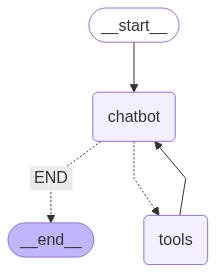

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
def stream_graph_responses(user_input: str):
    """Stream responses from the graph."""
    state = {"messages": [{"role": "user", "content": user_input}]}
    for response in graph.stream(state):
        print(response,"response bfore iterating values")
        for value in response.values():
            print(value)
            print("Assistant :", value["messages"][-1].content,end="")
user_input = "You are a customized greeting agent, so please greet Dinesh by using the greet tool."
stream_graph_responses(user_input)

{'chatbot': {'messages': [AIMessage(content=[{'type': 'text', 'text': "Certainly! I'll use the greet tool to create a customized greeting for Dinesh. Here's how we'll do that:"}, {'type': 'tool_use', 'name': 'greet', 'input': {'name': 'Dinesh'}, 'id': 'tooluse_ftHuvWmNRf-uA7PquANsBA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '2922dd1e-a7a4-4f23-9a19-378cde5a92a9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 26 Jun 2025 02:52:34 GMT', 'content-type': 'application/json', 'content-length': '388', 'connection': 'keep-alive', 'x-amzn-requestid': '2922dd1e-a7a4-4f23-9a19-378cde5a92a9'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [2039]}, 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--3183a93f-b36f-4972-900f-8ee13c6a8533-0', tool_calls=[{'name': 'greet', 'args': {'name': 'Dinesh'}, 'id': 'tooluse_ftHuvWmNRf-uA7PquANsBA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 378, 'output_tokens': 8